In [1]:
%load_ext rpy2.ipython

In [2]:
%%R

#install.packages("tibble")
#install.packages("dplyr")
#install.packages(ggplot2)
#install.packages("caret")
#install.packages("glmnet")

library(tibble)
library(dplyr)
library(ggplot2)
library(caret)
library(pROC)
library(ROSE)
library(glmnet)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: lattice
Type 'citation("pROC")' for a citation.

Attaching package: ‘pROC’

The following objects are masked from ‘package:stats’:

    cov, smooth, var

Loaded ROSE 0.0-4

Loading required package: Matrix
Loaded glmnet 4.1-8
In addition: Warning message:
In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages


In [3]:
%%R

binary_driving_mode <- function (df_chassis) {
    result <- ifelse(df_chassis$drivingMode == "COMPLETE_AUTO_DRIVE", 1, 0)

    return(result)
}


merge_chassis_pose <- function (df_chassis, df_pose) {
    
    
    df_chassis <- df_chassis[order(df_chassis$time), ]
    df_pose <- df_pose[order(df_pose$time), ]
    
    #make sure data is sorted by time fist

    chassis_time_arr <- df_chassis$time
    pose_time_arr <- df_pose$time

    matched_vector <- c()

    for (chassis_time in chassis_time_arr) {
        abs_time_diff_arr <- abs(pose_time_arr - chassis_time)

        min_index <-  which(abs_time_diff_arr == min(abs_time_diff_arr))
        
        matched_vector <-  c(matched_vector, pose_time_arr[min_index])
    }


    #df_chassis$matched <- df_pose$time[which(abs(pose_time_arr - df_chassis$time) == min(abs(pose_time_arr - df_chassis$time)))]
    df_chassis$matched <-  matched_vector
    df_pose$matched <-  df_pose$time


    return (list(df_chassis = df_chassis, df_pose = df_pose))


}

latlongStdDev <- function(df_pose){
    x <- df_pose["latitudeStdDev"]
    y <- df_pose["longitudeStdDev"]
    r <- sqrt(x^2 + y^2)

    return(r)

}


In [4]:
%%R
# Defining GMIDs for Red Routes
# Am creating a list of GMIDs for processing
green_route_gmIDs  <- c(
    "40706f50-f03b-11ee-b96e-fb353e7798cd",
"9df14b4e-f172-11ee-baa6-fb353e7798cd",
"88b0613a-d35d-11ee-b437-336917683bb8",
"7e3d64da-f12d-11ee-ba68-fb353e7798cd",
"fa9cba86-f0f0-11ee-ba2a-fb353e7798cd",
"7948628e-f20b-11ee-bb0f-fb353e7798cd",
"a231c0b0-f142-11ee-ba76-fb353e7798cd",
"a901fe40-f0fd-11ee-ba39-fb353e7798cd",
"99b9f446-f1b2-11ee-bad3-fb353e7798cd",
"c59a54e0-f179-11ee-baab-fb353e7798cd",
"25641404-cb66-11ee-909c-e1dc60cf66f9",
"14b6bc9c-f064-11ee-b998-fb353e7798cd",
"5c7a9ab2-f13b-11ee-ba72-fb353e7798cd",
"f8fd0fd8-f243-11ee-bb3f-fb353e7798cd",
"4c88757c-f157-11ee-ba89-fb353e7798cd",
"ba87f3ec-f07e-11ee-b9b4-fb353e7798cd",
"58d78342-f24a-11ee-bb45-fb353e7798cd",
"de493be2-f10f-11ee-ba4b-fb353e7798cd",
"848e44a6-f134-11ee-ba6d-fb353e7798cd",
"3d8020aa-cb7f-11ee-909c-e1dc60cf66f9",
"c4fca7bc-f18e-11ee-bab8-fb353e7798cd",
"c4146d46-f074-11ee-b9ac-fb353e7798cd",
"fe0395f0-f1ea-11ee-baf9-fb353e7798cd",
"271fee10-cb8b-11ee-909c-e1dc60cf66f9",
"5fc763f6-f1ab-11ee-bacd-fb353e7798cd",
"b3ee0dd8-f0d7-11ee-ba18-fb353e7798cd",
"a08a8c7e-f1fb-11ee-bb05-fb353e7798cd",
"7f824ea2-f05e-11ee-b993-fb353e7798cd",
"96ceec56-f1cf-11ee-bae4-fb353e7798cd",
"0f3cdf60-f1f6-11ee-bb00-fb353e7798cd",
"53fad09e-f0f7-11ee-ba2f-fb353e7798cd",
"f570c51c-f15d-11ee-ba91-fb353e7798cd",
"cbdc93f4-f255-11ee-bb4e-fb353e7798cd",
"d7cb9c92-f164-11ee-ba97-fb353e7798cd",
"7a22a34c-f1f0-11ee-bafe-fb353e7798cd",
"d454c586-f11c-11ee-ba55-fb353e7798cd",
"837fc882-cb5a-11ee-909c-e1dc60cf66f9",
"8e5c4fc2-f149-11ee-ba7f-fb353e7798cd",
"c2f54552-f06f-11ee-b9a9-fb353e7798cd",
"43abeb00-f206-11ee-bb07-fb353e7798cd",
"25135418-f250-11ee-bb4a-fb353e7798cd",
"f9c5e53e-f0ea-11ee-ba28-fb353e7798cd",
"4cf81634-f238-11ee-bb34-fb353e7798cd",
"d846a080-f115-11ee-ba51-fb353e7798cd",
"1c74d294-f1e4-11ee-baf0-fb353e7798cd",
"3c415ade-d353-11ee-b437-336917683bb8",
"8adb6498-f04d-11ee-b981-fb353e7798cd",
"de226278-f25a-11ee-bb4e-fb353e7798cd",
"c14299be-f180-11ee-bab0-fb353e7798cd",
"870cfd32-f1b9-11ee-bad5-fb353e7798cd",
"3ed4aa16-f1d6-11ee-bae6-fb353e7798cd",
"df6c3fb4-f200-11ee-bb07-fb353e7798cd",
"5f7ce340-f1c8-11ee-bae0-fb353e7798cd",
"b31aca98-cb95-11ee-909c-e1dc60cf66f9",
"f12112ba-f1c0-11ee-bada-fb353e7798cd",
"73bc30cc-f150-11ee-ba84-fb353e7798cd",
"3a7dc9a6-f042-11ee-b974-fb353e7798cd",
"dea29156-f123-11ee-ba5d-fb353e7798cd",
"044d976e-f0e5-11ee-ba20-fb353e7798cd",
"961fd9cc-f103-11ee-ba3f-fb353e7798cd",
"bbbd0cc6-f0dc-11ee-ba1e-fb353e7798cd",
"9736e77c-f187-11ee-bab6-fb353e7798cd",
"5774dcde-f196-11ee-babe-fb353e7798cd",
"ece2a8be-f047-11ee-b97d-fb353e7798cd",
"3ec95686-f053-11ee-b988-fb353e7798cd",
"51b74168-f19d-11ee-babf-fb353e7798cd",
"bb4d37d4-f109-11ee-ba46-fb353e7798cd",
"cf7148d8-f058-11ee-b98a-fb353e7798cd",
"bf9157f0-f16b-11ee-ba9e-fb353e7798cd",
"98692fde-f1a4-11ee-bac6-fb353e7798cd",
"25e27b86-f06a-11ee-b9a3-fb353e7798cd",
"a6539bd2-cb72-11ee-909c-e1dc60cf66f9",
"5afabc8c-f035-11ee-b966-fb353e7798cd",
"c1b320e2-f079-11ee-b9b0-fb353e7798cd",
"d1a3a310-f091-11ee-b9ce-fb353e7798cd",
"e9a1d768-f23d-11ee-bb39-fb353e7798cd",
"c9be2042-f0de-11ee-ba1e-fb353e7798cd",
"ed352100-cba0-11ee-909c-e1dc60cf66f9",
"8b0593cc-cb4e-11ee-909c-e1dc60cf66f9",
"236836f6-f1dd-11ee-bae8-fb353e7798cd",
"072ef896-cbac-11ee-909c-e1dc60cf66f9"
)

In [5]:
%%R
# Initialize an empty tibble
df_merged <- tibble()

# Loop through each gmID
for (id in green_route_gmIDs) {
  print(id)
  
  # Update the file paths with the correct full paths
  temp_chassis_path <- sprintf(
    "/home/gampadu_linux/Desktop/TDMprivate/data/%s/_apollo_canbus_chassis/%s_apollo_canbus_chassis.csv",
    id, id
  )
  temp_pose_path <- sprintf(
    "/home/gampadu_linux/Desktop/TDMprivate/data/%s/_apollo_sensor_gnss_best_pose/%s_apollo_sensor_gnss_best_pose.csv",
    id, id
  )

  # Check if the files exist
  if (file.exists(temp_chassis_path) && file.exists(temp_pose_path)) {
    # Read the files
    temp_chassis <- as_tibble(read.csv(temp_chassis_path))
    temp_pose <- as_tibble(read.csv(temp_pose_path))
    
    # Process the data
    r <- latlongStdDev(temp_pose)
    temp_pose["latlongStdDev"] <- r
    
    results <- merge_chassis_pose(temp_chassis, temp_pose)
    result_full <- full_join(results$df_chassis, results$df_pose, by = "matched")
    
    # Add binary driving mode
    result_full$binaryDrivingMode <- binary_driving_mode(result_full)
    
    # Append to df_merged
    df_merged <- bind_rows(df_merged, result_full)
  } else {
    warning(sprintf("Files not found for gmID: %s", id))
  }
}

print("Done loading data")

[1] "40706f50-f03b-11ee-b96e-fb353e7798cd"
[1] "9df14b4e-f172-11ee-baa6-fb353e7798cd"
[1] "88b0613a-d35d-11ee-b437-336917683bb8"
[1] "7e3d64da-f12d-11ee-ba68-fb353e7798cd"
[1] "fa9cba86-f0f0-11ee-ba2a-fb353e7798cd"
[1] "7948628e-f20b-11ee-bb0f-fb353e7798cd"
[1] "a231c0b0-f142-11ee-ba76-fb353e7798cd"
[1] "a901fe40-f0fd-11ee-ba39-fb353e7798cd"
[1] "99b9f446-f1b2-11ee-bad3-fb353e7798cd"
[1] "c59a54e0-f179-11ee-baab-fb353e7798cd"
[1] "25641404-cb66-11ee-909c-e1dc60cf66f9"
[1] "14b6bc9c-f064-11ee-b998-fb353e7798cd"
[1] "5c7a9ab2-f13b-11ee-ba72-fb353e7798cd"
[1] "f8fd0fd8-f243-11ee-bb3f-fb353e7798cd"
[1] "4c88757c-f157-11ee-ba89-fb353e7798cd"
[1] "ba87f3ec-f07e-11ee-b9b4-fb353e7798cd"
[1] "58d78342-f24a-11ee-bb45-fb353e7798cd"
[1] "de493be2-f10f-11ee-ba4b-fb353e7798cd"
[1] "848e44a6-f134-11ee-ba6d-fb353e7798cd"
[1] "3d8020aa-cb7f-11ee-909c-e1dc60cf66f9"
[1] "c4fca7bc-f18e-11ee-bab8-fb353e7798cd"
[1] "c4146d46-f074-11ee-b9ac-fb353e7798cd"
[1] "fe0395f0-f1ea-11ee-baf9-fb353e7798cd"
[1] "271fee

In [12]:
%%R
# Load required library
library(dplyr)

# Split GMIDs into Training and Testing Sets
training_gmIDs <- green_route_gmIDs[1:65]  # First 65 GMIDs (80%)
testing_gmIDs <- green_route_gmIDs[66:81] # Last 16 GMIDs (20%)

# Filter df_merged for training and testing data based on GMIDs
train_data <- df_merged %>% filter(groupMetadataID.x %in% training_gmIDs)
test_data <- df_merged %>% filter(groupMetadataID.x %in% testing_gmIDs)

# Check the number of rows in each dataset
print(paste("Training data rows:", nrow(train_data)))
print(paste("Testing data rows:", nrow(test_data)))

# Verify if test_data is not empty
if (nrow(test_data) == 0) {
  print("Error: test_data is empty. Check GMID filtering.")
}

[1] "Training data rows: 1720748"
[1] "Testing data rows: 456645"


In [13]:
%%R
# Train a Logistic Regression Model
model <- glm(
  binaryDrivingMode ~ speedMps + throttlePercentage + brakePercentage + steeringPercentage + latlongStdDev,
  data = train_data,
  family = binomial
)

summary(model)


Call:
glm(formula = binaryDrivingMode ~ speedMps + throttlePercentage + 
    brakePercentage + steeringPercentage + latlongStdDev, family = binomial, 
    data = train_data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.5772   0.1762   0.2696   0.4635   4.3982  

Coefficients:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)        -0.8545621  0.0068173 -125.35   <2e-16 ***
speedMps            0.1786764  0.0004709  379.43   <2e-16 ***
throttlePercentage  0.0359135  0.0002764  129.94   <2e-16 ***
brakePercentage     0.0558603  0.0002850  196.00   <2e-16 ***
steeringPercentage -0.0061761  0.0001533  -40.29   <2e-16 ***
latlongStdDev      -0.4219570  0.0029004 -145.49   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1206128  on 1720747  degrees of freedom
Residual deviance:  932834  on 1720742  degrees of freedom
AIC: 932846

Numbe

In [14]:
%%R
 # Predict on the test set
 predictions <- predict(model, test_data, type = "response")

 #Covert probabilities to binary classes (0 or 1)
 predicted_classes <- ifelse(predictions > 0.5, 1, 0)

 # Calculate accuracy
 accuracy <- mean(predicted_classes == test_data$binaryDrivingMode)

 # Print the accuracy
print(paste("Accuracy:", accuracy))

[1] "Accuracy: 0.872198315978495"


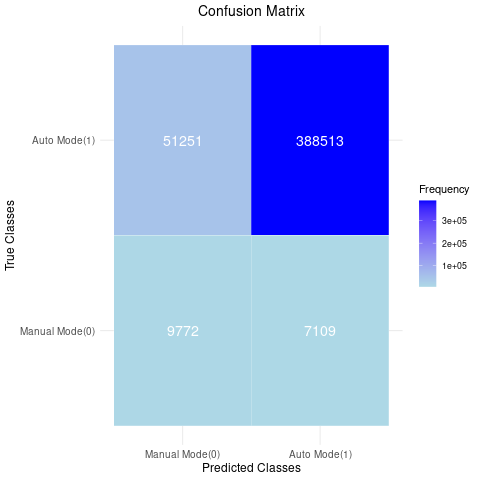

In [18]:
%%R
# Load required libraries
library(ggplot2)
library(caret)

# Map the values to labels (1 -> "Auto_mode", 0 -> "Manual")
predicted_classes_labeled <- factor(predicted_classes, levels = c(0,1), labels = c("Manual Mode(0)", "Auto Mode(1)"))
actual_classes_labeled <- factor (test_data$binaryDrivingMode, levels = c(0,1), labels = c("Manual Mode(0)", "Auto Mode(1)"))

# Generate the confusion matrix
cm <- confusionMatrix(predicted_classes_labeled, actual_classes_labeled)
cm_table <- as.data.frame(cm$table)

# Rename columns for better understanding
colnames(cm_table) <- c("Actual", "Predicted", "Frequency")

# Create the colored confusion matrix plot
ggplot(cm_table, aes(x = Predicted, y = Actual, fill = Frequency)) +
  geom_tile(color = "white") +
  scale_fill_gradient(low = "lightblue", high = "blue", name = "Frequency") +
  geom_text(aes(label = Frequency), color = "white", size = 5) +
  labs(title = "Confusion Matrix", x = "Predicted Classes", y = "True Classes") +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5, size = 14),
        axis.title = element_text(size = 12),
        axis.text = element_text(size = 10))

Area under the curve: 0.7443


Setting levels: control = 0, case = 1
Setting direction: controls < cases


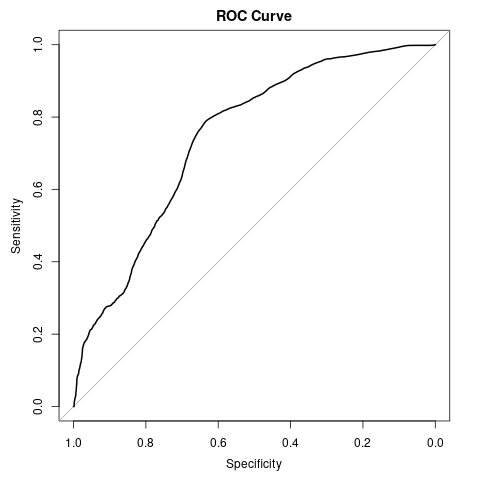

In [16]:
%%R

library(pROC)
roc_obj <- roc(test_data$binaryDrivingMode, predictions)
plot(roc_obj, main = "ROC Curve")
auc(roc_obj)

In [17]:
%%R
#Manually calculating the confusion matrix values
TP <- 388513
FP <- 7109
FN <- 51251
TN <- 9772

# Calculate Metrics
accuracy <- (TP + TN) / (TP + TN + FP + FN)
precision <- TP / (TP + FP)
recall <- TP / (TP + FN)

#Print Metrics
cat("Accuracy:", accuracy, "\n")
cat("Precision:", precision, "\n")
cat("Recall:", recall, "\n")

Accuracy: 0.8721983 
Precision: 0.9820308 
Recall: 0.8834579 


In [11]:
%%R

#Manually calculating the confusion matrix values
TP <- sum(predicted_classes == 1 & test_data$binaryDrivingMode  == 1)
FP <- sum(predicted_classes == 1 & test_data$binaryDrivingMode == 0)
FN <- sum(predicted_classes == 0 & test_data$binaryDrivingMode  == 1)
TN <- sum(predicted_classes == 0 & test_data$binaryDrivingMode  == 0)

#Calculating Precision, Recall and F1 Score with Safeguard
if (TP == 0) {
    precision <- 0
    recall <- 0
    f1_score <- 0 
} else {
precision <- TP / (TP + FP) #Precision
recall <- TP / (TP + FN) #Recall
f1_score <- 2 * (precision * recall) / (precision + recall) #F1_score
}

#Display the metrics
cat("Precision:", precision, "\n")
cat("Recall:", recall, "\n")
cat("F1_score:", f1_score,  "\n")

Precision: 0.8834579 
Recall: 0.9820308 
F1_score: 0.9301401 
